In [1]:
import argparse
import yaml
from tqdm import tqdm
import sys
import copy
from functools import partial
import os


import pickle

import jax
import jaxopt 
from jax.flatten_util import ravel_pytree


jax.config.update("jax_enable_x64", False)
# jax.config.update("jax_log_compiles", True)

import jax.numpy as jnp
import optax   

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from utils.function_utils import polynomial, taylor_expand_in_alpha
from utils.distribution_utils import build_q_mstar
from rikabplotlib.plot_utils import newplot

from utils.fit_utils import randomize_params, freeze_lower_orders, create_mask

# time
from time import time

from helpers.data import get_pdf_toy_JAX, read_in_data_JAX

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Initialization and Setup

In [2]:
# TODO: Replace this with Radha's YAML files
mstar = 1
m = 1
n = 7
dist = "thrust"  # "thrust" or "exponential"

# number of higher orders
m0 = 1
n0 = 0 # Default is 0

tag = f"gaussian_{dist}_stat_m0{m0}_low"


mult_factor = 2 if dist == "thrust" else 1

T_MAX = 10
gaussian_prior_param = 0.5 # std of g/m!n!
alpha_init = 0.118


zero_error_scale = 1   # Fraction of minimum error to set error on 0, default is 1
lr = 0.00100
weight_decay = 0.0001
epochs = 50000
batch_size = 320*1
seed = 42
freeze_previous_order = False   # NEW
bogo_init = True
random_batch = False

ignore_left = False # Ignore the leftmost point 
x_mask = [0.05, 0.45]

name = f"{dist}_m{m}_n{n}"
init_from = f"{dist}_m{m-1}_n{n}"

# Seed stuff
np.random.seed(seed)
jax_key = jax.random.PRNGKey(seed)



beta_limits = [0, 1e6]
alpha_limits = [0.1, 0.14]






### Aesthetic Setup


In [3]:
order_colors = {1 : "blue", 2 : "purple", 3 : "red"}

# Colors
colors = ["red", "violet", "blue"][::-1]
darkcolors = ["darkred", "darkviolet", "darkblue"][::-1]
order_strings = {1 : r"$\mathcal{O}(\alpha_s^{1})$", 2 : r"$\mathcal{O}(\alpha_s^{2})$", 3 : r"$\mathcal{O}(\alpha_s^{3})$"}


### Parameter Initialization from Fixed Order Calc

In [4]:
# Init from previous file:

def initialize_params(name_, order):

    # Initialize params
    params_ = {
        "g_star" : -np.zeros((order+2 - mstar, n+1+n0)),
        "g_coeffs" : -np.zeros((order+2 - mstar, n+1+n0)),
        "thetas" : np.zeros((order+2 - mstar,)) ,
        "thetas_coeffs" : np.zeros((order+2 - mstar,)) ,
        "temps" : 1 * np.ones((order+2 - mstar,)),
        "temps_coeffs" : 1 * np.ones((order+2 - mstar,)),
        "temps_positive" : 0.1 * np.ones((order+2 - mstar,)),
    }

    try:
        with open(f"output_JAX/{name_}_params.pkl", "rb") as f:
            init_params = copy.deepcopy(pickle.load(f))

        g_coeffs_init = init_params["g_coeffs"]
        g_star_init = init_params["g_star"]
        thetas_init = init_params["thetas"]
        thetas_coeffs_init = init_params["thetas_coeffs"]
        temps_init = init_params["temps"]
        temps_coeffs_init = init_params["temps_coeffs"]
        temps_pos_init = init_params["temps_positive"]


        init_m, init_n = g_coeffs_init.shape

        params_["g_coeffs"][:init_m, :init_n] = copy.deepcopy(g_coeffs_init)
        params_["g_star"][:init_m, :init_n] = copy.deepcopy(g_star_init)
        params_["thetas"][:init_m] = copy.deepcopy(thetas_init)
        params_["thetas_coeffs"][:init_m] = copy.deepcopy(thetas_coeffs_init)
        params_["temps"][:init_m] = copy.deepcopy(temps_init) 
        params_["temps_coeffs"][:init_m] = copy.deepcopy(temps_coeffs_init)
        params_["temps_positive"][:init_m] = copy.deepcopy(temps_pos_init)

        
        

        for k in params_.keys():
            params_[k] = jnp.array(params_[k])

        
        params_["g_coeffs"] = params_["g_coeffs"].at[params_["g_coeffs"].shape[0]-mstar:,:].set(0)  # Current order doesn't count
        params_["thetas_coeffs"] = params_["thetas_coeffs"].at[params_["thetas_coeffs"].shape[0]-mstar:,].set(-1)  # Current order doesn't count
        params_["temps_coeffs"] = params_["temps_coeffs"].at[params_["temps_coeffs"].shape[0]-mstar:,].set(1e-1)  # Current order doesn't count


        return copy.deepcopy(params_)
    
    except:
        print(f"No file" + f"output_JAX/{name_}_params.pkl")
        


params1 = initialize_params(f"{dist}_m1_n{n}", 1 + m0 -1)
params2 = initialize_params(f"{dist}_m2_n{n}", 2 + m0 -1)
params3 = initialize_params(f"{dist}_m3_n{n}", 3 + m0 -1)




factorials = np.ones_like(params3["g_star"])
for mi in range(params3["g_star"].shape[0]):
    for ni in range(params3["g_star"].shape[1]):
        factorials[mi, ni] = 1 / math.factorial(mi + mstar) / math.factorial(ni)



params_array = [params1, params2, params3]

def np_to_jax(p):

    for k in p.keys():
        p[k] = jnp.array(p[k])

    return p

params1 = np_to_jax(params1)
params2 = np_to_jax(params2)
params3 = np_to_jax(params3)



# if init_from:
#     params = init_params(init_from)

# # Save the original params for the purpose of freezing
# original_params = params.copy()

# Compilation

In [5]:

q = build_q_mstar(mstar)

# compile
q_vmap = jax.vmap(q, in_axes=(0,None,None,None,None,None,None,None,None))


# Taylor Expansions
q0_vmap = jax.vmap(taylor_expand_in_alpha(q, 0), in_axes=(0,None,None,None,None,None,None,None,None))
q1_vmap = jax.vmap(taylor_expand_in_alpha(q, 1), in_axes=(0,None,None,None,None,None,None,None,None))
q2_vmap = jax.vmap(taylor_expand_in_alpha(q, 2), in_axes=(0,None,None,None,None,None,None,None,None))
q3_vmap = jax.vmap(taylor_expand_in_alpha(q, 3), in_axes=(0,None,None,None,None,None,None,None,None))
# ... Add more if necessary, can loop if we really have to

qm_vmap = [q0_vmap, q1_vmap, q2_vmap, q3_vmap]

# ##### Second vmap over alpha #####
q_vmap2 = jax.vmap(q_vmap, in_axes = (None, 0, None, None, None, None, None, None, None))
qm_vmap2 = []
for qi in qm_vmap:
    qi_vmap2 = jax.vmap(qi, in_axes = (None, 0, None, None, None, None, None, None, None))
    qm_vmap2.append(qi_vmap2)



# Select the Taylor Expansion Function
CHOSEN_Q_VMAP = qm_vmap[m]
CHOSEN_Q_VMAP2 = qm_vmap2[m]


# Helper functions

ns = jnp.arange(0, n+1+n0)
t_reg = 1.0 #/ jnp.mean(0.5)
twopi = 1 #s2 * jnp.pi
t_pows = jnp.power(t_reg, ns)


@partial(jax.jit, static_argnames=())
def Q_ANSATZ(ts, alpha, params):



    orders = jnp.arange(params["g_star"].shape[0]) + mstar  # physical power index per row
    tscale = t_pows[None, :]                                 # (1, n+1)
    ascale = ((alpha / twopi ) ** orders)[:, None]                      # (m_rows, 1)

    g_star = params["g_star"].at[-m0:].set(params["g_star"][-m0:] / ascale[-m0:] * tscale)
    g_coeffs = params["g_coeffs"].at[-m0-mstar:-mstar].set(params["g_coeffs"][-m0-mstar:-mstar] / ascale[-m0-mstar:-mstar] * tscale)

    # Positive temps
    temps = params["temps"].at[-m0:].set( jax.nn.softplus( params["temps"][-m0:]))
    temps_coeffs = params["temps_coeffs"].at[-m0-mstar:-mstar].set( jax.nn.softplus(params["temps_coeffs"][-m0-mstar:-mstar]))
    temps_pos = params["temps_positive"].at[-m0:].set(jax.nn.softplus( params["temps_positive"][-m0:]))
    temps_coeffs = temps_coeffs.at[-mstar:].set(1e-1)

    g_coeffs = g_coeffs.at[g_coeffs.shape[0]-mstar:,:].set(0)  # Current order doesn't count
    thetas_coeffs = params["thetas_coeffs"].at[g_coeffs.shape[0]-mstar:,].set(-1)  # Current order doesn't count
    temps_coeffs = temps_coeffs.at[g_coeffs.shape[0]-mstar:,].set(1e-1)  # Current order doesn't count



    return q_vmap(ts, alpha, g_star, g_coeffs,
                  params["thetas"], thetas_coeffs,
                 temps, temps_coeffs, temps_pos)



# Data Setup

Opal Data from https://www.hepdata.net/record/ins440721?version=1&table=Table%203

ALEPH Data from https://www.hepdata.net/record/ins636645?version=1&table=Table%2054

In [6]:

LEP = {
    "THRUST": 1-np.array([
        0.585,0.595,0.605,0.615,0.625,0.635,0.645,0.655,0.665,0.675,
        0.685,0.695,0.705,0.715,0.725,0.735,0.745,0.755,0.765,0.775,
        0.785,0.795,0.805,0.815,0.825,0.835,0.845,0.855,0.865,0.875,
        0.885,0.895,0.905,0.915,0.925,0.935,0.945,0.955,0.965,0.975,
        0.985,0.995
    ]),
    "THRUST_HIGH": 1-np.array([
        0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,
        0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,
        0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,
        0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,
        0.98,0.99
    ]),
    "THRUST_LOW": 1-np.array([
        0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,
        0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,
        0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,
        0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,
        0.99,1.0
    ]),
    "DSIG": np.array([
        0.00115,0.00229,0.0035,0.00839,0.01283,0.02148,0.0433,0.06556,0.10284,0.12575,
        0.16396,0.18416,0.21424,0.24814,0.29427,0.34347,0.36536,0.43088,0.46923,0.54584,
        0.59942,0.66087,0.768,0.857,0.98079,1.1127,1.27035,1.43939,1.63938,1.93459,
        2.23002,2.63072,3.06214,3.70212,4.54709,5.64464,7.27722,9.62952,13.60396,18.56511,
        12.88646,1.31186
    ]),
    "stat_plus": np.array([
        0.00034,0.0005,0.00061,0.00096,0.00116,0.00152,0.00223,0.00267,0.00334,0.00366,
        0.00418,0.00449,0.00466,0.00511,0.00567,0.00609,0.00614,0.00691,0.00709,0.0079,
        0.00814,0.00856,0.00928,0.00974,0.0106,0.01125,0.01209,0.01339,0.01372,0.01504,
        0.01641,0.01811,0.01892,0.02073,0.02343,0.02568,0.02929,0.03385,0.04085,0.04923,
        0.03872,0.00986
    ]),
    "stat_minus": np.array([
        -0.00034,-0.0005,-0.00061,-0.00096,-0.00116,-0.00152,-0.00223,-0.00267,-0.00334,-0.00366,
        -0.00418,-0.00449,-0.00466,-0.00511,-0.00567,-0.00609,-0.00614,-0.00691,-0.00709,-0.0079,
        -0.00814,-0.00856,-0.00928,-0.00974,-0.0106,-0.01125,-0.01209,-0.01339,-0.01372,-0.01504,
        -0.01641,-0.01811,-0.01892,-0.02073,-0.02343,-0.02568,-0.02929,-0.03385,-0.04085,-0.04923,
        -0.03872,-0.00986
    ]),
    "sys1_plus": np.array([
        0.00052,0.00093,0.00087,0.00077,0.00082,0.00095,0.00496,0.00273,0.00353,0.00297,
        0.00474,0.00871,0.00455,0.01328,0.00573,0.00801,0.00707,0.00868,0.01309,0.00687,
        0.00809,0.02434,0.0152,0.01211,0.01281,0.00939,0.00874,0.00965,0.02383,0.02559,
        0.0291,0.01555,0.03499,0.0235,0.03555,0.03708,0.0454,0.07026,0.07561,0.08476,
        0.22928,0.19542
    ]),
    "sys1_minus": np.array([
        -0.00052,-0.00093,-0.00087,-0.00077,-0.00082,-0.00095,-0.00496,-0.00273,-0.00353,-0.00297,
        -0.00474,-0.00871,-0.00455,-0.01328,-0.00573,-0.00801,-0.00707,-0.00868,-0.01309,-0.00687,
        -0.00809,-0.02434,-0.0152,-0.01211,-0.01281,-0.00939,-0.00874,-0.00965,-0.02383,-0.02559,
        -0.0291,-0.01555,-0.03499,-0.0235,-0.03555,-0.03708,-0.0454,-0.07026,-0.07561,-0.08476,
        -0.22928,-0.19542
    ]),
    "sys2_plus": np.array([
        0.00033,0.00065,0.001,0.0017,0.0026,0.00436,0.00307,0.00464,0.00728,0.00984,
        0.01283,0.01441,0.01503,0.01741,0.02065,0.01874,0.01993,0.0235,0.01728,0.0201,
        0.02208,0.02607,0.0303,0.03381,0.04685,0.05316,0.06069,0.052,0.05922,0.06989,
        0.06846,0.08076,0.09401,0.07685,0.09439,0.11718,0.11117,0.1471,0.20781,0.68299,
        0.47408,0.04826
    ]),
    "sys2_minus": np.array([
        -0.00033,-0.00065,-0.001,-0.0017,-0.0026,-0.00436,-0.00307,-0.00464,-0.00728,-0.00984,
        -0.01283,-0.01441,-0.01503,-0.01741,-0.02065,-0.01874,-0.01993,-0.0235,-0.01728,-0.0201,
        -0.02208,-0.02607,-0.0303,-0.03381,-0.04685,-0.05316,-0.06069,-0.052,-0.05922,-0.06989,
        -0.06846,-0.08076,-0.09401,-0.07685,-0.09439,-0.11718,-0.11117,-0.1471,-0.20781,-0.68299,
        -0.47408,-0.04826
    ]),
}


OPAL = {
    "THRUST": 1-np.array([0.74,0.815,0.865,0.895,0.92,0.94,0.955,0.965,0.975,0.985,0.995]),
    "THRUST_HIGH": 1-np.array([0.7,0.78,0.85,0.88,0.91,0.93,0.95,0.96,0.97,0.98,0.99]),
    "THRUST_LOW": 1-np.array([0.78,0.85,0.88,0.91,0.93,0.95,0.96,0.97,0.98,0.99,1.0]),
    "DSIG": np.array([0.14,0.93,1.02,3.1,3.56,3.92,6.5,10.1,18.1,22.1,8.6]),
    "stat_plus": np.array([0.12,0.24,0.39,0.64,0.82,0.84,1.5,1.9,2.5,2.9,1.7]),
    "stat_minus": np.array([-0.12,-0.24,-0.39,-0.64,-0.82,-0.84,-1.5,-1.9,-2.5,-2.9,-1.7]),
    "sys_plus": np.array([0.47,0.47,0.61,0.59,0.81,1.29,1.4,1.6,2.6,2.6,2.6]),
    "sys_minus": np.array([-0.47,-0.47,-0.61,-0.59,-0.81,-1.29,-1.4,-1.6,-2.6,-2.6,-2.6]),
}



LEP_C = {
    "C_PARAMETER": np.array([
        0.01,0.03,0.05,0.07,0.09,0.11,0.13,0.15000000000000002,0.16999999999999998,0.19,
        0.21000000000000002,0.22999999999999998,0.25,0.27,0.29000000000000004,0.31,0.33,0.35,
        0.37,0.39,0.41000000000000003,0.43,0.45,0.47,0.49,0.51,0.53,0.55,0.5700000000000001,
        0.59,0.61,0.63,0.65,0.67,0.69,0.71,0.73,0.75,0.77,0.79,0.81,0.83,0.85,0.87,0.89,
        0.91,0.9299999999999999,0.95,0.97,0.99
    ]),
    "C_PARAMETER_LOW": np.array([
        0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,
        0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,
        0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,
        0.6,0.62,0.64,0.66,0.68,0.7,0.72,0.74,0.76,0.78,0.8,0.82,0.84,0.86,
        0.88,0.9,0.92,0.94,0.96,0.98
    ]),
    "C_PARAMETER_HIGH": np.array([
        0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,
        0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,0.4,
        0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,0.6,
        0.62,0.64,0.66,0.68,0.7,0.72,0.74,0.76,0.78,0.8,0.82,0.84,0.86,0.88,
        0.9,0.92,0.94,0.96,0.98,1.0
    ]),
    # (1/SIG) * d(SIG)/dC
    "DSIG": np.array([
        0.06711,0.17252,0.99038,2.63786,4.05142,4.37476,3.97532,3.42243,2.92973,2.54854,
        2.25012,1.97701,1.80134,1.60594,1.45321,1.29952,1.18603,1.08169,1.01995,0.92768,
        0.86267,0.79512,0.75074,0.69408,0.62931,0.60227,0.5587,0.53272,0.50388,0.45918,
        0.42642,0.40984,0.37779,0.35563,0.34,0.32205,0.30286,0.28838,0.27147,0.22742,
        0.17542,0.11919,0.08324,0.05707,0.03548,0.02111,0.01266,0.00892,0.00292,0.00091
    ]),
    "stat_plus": np.array([
        0.00206,0.00263,0.00696,0.01272,0.01632,0.0169,0.01579,0.01428,0.01312,0.01221,
        0.01154,0.0108,0.01055,0.00982,0.0093,0.00868,0.00832,0.00791,0.00784,0.00744,
        0.00711,0.00706,0.00729,0.00639,0.00597,0.00588,0.0057,0.0058,0.00539,0.00505,
        0.00483,0.00477,0.00455,0.00444,0.00434,0.00414,0.00404,0.00393,0.00378,0.00347,
        0.00305,0.00244,0.00204,0.00168,0.00131,0.00105,0.00078,0.00073,0.00039,0.00026
    ]),
    "stat_minus": np.array([
        -0.00206,-0.00263,-0.00696,-0.01272,-0.01632,-0.0169,-0.01579,-0.01428,-0.01312,-0.01221,
        -0.01154,-0.0108,-0.01055,-0.00982,-0.0093,-0.00868,-0.00832,-0.00791,-0.00784,-0.00744,
        -0.00711,-0.00706,-0.00729,-0.00639,-0.00597,-0.00588,-0.0057,-0.0058,-0.00539,-0.00505,
        -0.00483,-0.00477,-0.00455,-0.00444,-0.00434,-0.00414,-0.00404,-0.00393,-0.00378,-0.00347,
        -0.00305,-0.00244,-0.00204,-0.00168,-0.00131,-0.00105,-0.00078,-0.00073,-0.00039,-0.00026
    ]),
    "sys1_plus": np.array([
        0.06509,0.01442,0.02565,0.05487,0.04694,0.02342,0.02199,0.02026,0.02512,0.01471,
        0.01269,0.02161,0.01908,0.01097,0.00687,0.01328,0.01153,0.00587,0.00483,0.0082,
        0.00982,0.00405,0.01128,0.00353,0.0118,0.00746,0.01023,0.0099,0.0055,0.01068,
        0.00323,0.00518,0.00289,0.00993,0.00323,0.00484,0.0048,0.00401,0.00518,0.0072,
        0.00384,0.00337,0.00515,0.00315,0.00368,0.0018,0.00131,0.00101,0.00034,0.00024
    ]),
    "sys1_minus": np.array([
        -0.06509,-0.01442,-0.02565,-0.05487,-0.04694,-0.02342,-0.02199,-0.02026,-0.02512,-0.01471,
        -0.01269,-0.02161,-0.01908,-0.01097,-0.00687,-0.01328,-0.01153,-0.00587,-0.00483,-0.0082,
        -0.00982,-0.00405,-0.01128,-0.00353,-0.0118,-0.00746,-0.01023,-0.0099,-0.0055,-0.01068,
        -0.00323,-0.00518,-0.00289,-0.00993,-0.00323,-0.00484,-0.0048,-0.00401,-0.00518,-0.0072,
        -0.00384,-0.00337,-0.00515,-0.00315,-0.00368,-0.0018,-0.00131,-0.00101,-0.00034,-0.00024
    ]),
    "sys2_plus": np.array([
        0.00359,0.00923,0.05299,0.13588,0.2087,0.22536,0.07322,0.06303,0.05396,0.02651,
        0.02341,0.02057,0.01403,0.01251,0.01132,0.03732,0.03407,0.03107,0.03409,0.03101,
        0.02883,0.02006,0.01894,0.01751,0.02304,0.02205,0.02045,0.01804,0.01707,0.01555,
        0.02101,0.02019,0.01861,0.01378,0.01317,0.01248,0.01338,0.01274,0.01199,0.02049,
        0.01581,0.01074,0.0101,0.00693,0.00431,0.00442,0.00265,0.00187,0.00065,0.0002
    ]),
    "sys2_minus": np.array([
        -0.00359,-0.00923,-0.05299,-0.13588,-0.2087,-0.22536,-0.07322,-0.06303,-0.05396,-0.02651,
        -0.02341,-0.02057,-0.01403,-0.01251,-0.01132,-0.03732,-0.03407,-0.03107,-0.03409,-0.03101,
        -0.02883,-0.02006,-0.01894,-0.01751,-0.02304,-0.02205,-0.02045,-0.01804,-0.01707,-0.01555,
        -0.02101,-0.02019,-0.01861,-0.01378,-0.01317,-0.01248,-0.01338,-0.01274,-0.01199,-0.02049,
        -0.01581,-0.01074,-0.0101,-0.00693,-0.00431,-0.00442,-0.00265,-0.00187,-0.00065,-0.0002
    ]),
}


def add_total_error_columns(d,):

    running_err2 = d["stat_plus"]**2
    # for key in d.keys():
    #     if "sys" in key and "plus" in key:
    #         running_err2 += d[key]**2

    d["total_err"] = np.sqrt(running_err2)

    return d

LEP = add_total_error_columns(LEP)
OPAL = add_total_error_columns(OPAL)

LEP_C = add_total_error_columns(LEP_C)

print(LEP["DSIG"])
print(LEP["total_err"])

[1.150000e-03 2.290000e-03 3.500000e-03 8.390000e-03 1.283000e-02
 2.148000e-02 4.330000e-02 6.556000e-02 1.028400e-01 1.257500e-01
 1.639600e-01 1.841600e-01 2.142400e-01 2.481400e-01 2.942700e-01
 3.434700e-01 3.653600e-01 4.308800e-01 4.692300e-01 5.458400e-01
 5.994200e-01 6.608700e-01 7.680000e-01 8.570000e-01 9.807900e-01
 1.112700e+00 1.270350e+00 1.439390e+00 1.639380e+00 1.934590e+00
 2.230020e+00 2.630720e+00 3.062140e+00 3.702120e+00 4.547090e+00
 5.644640e+00 7.277220e+00 9.629520e+00 1.360396e+01 1.856511e+01
 1.288646e+01 1.311860e+00]
[0.00034 0.0005  0.00061 0.00096 0.00116 0.00152 0.00223 0.00267 0.00334
 0.00366 0.00418 0.00449 0.00466 0.00511 0.00567 0.00609 0.00614 0.00691
 0.00709 0.0079  0.00814 0.00856 0.00928 0.00974 0.0106  0.01125 0.01209
 0.01339 0.01372 0.01504 0.01641 0.01811 0.01892 0.02073 0.02343 0.02568
 0.02929 0.03385 0.04085 0.04923 0.03872 0.00986]


-0.86790880411953


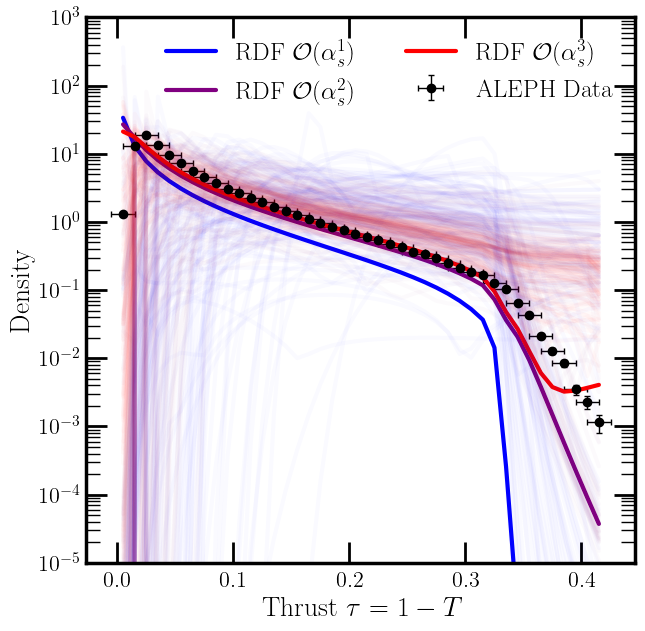

In [7]:
if dist == "thrust":

    xLEP_bin_centers = LEP["THRUST"]
    tLEP_bin_centers = np.log(1/(2 * xLEP_bin_centers))
    
    min_value = np.exp(-T_MAX ) / 2


    xLEP_low = LEP["THRUST_LOW"]
    xLEP_high = LEP["THRUST_HIGH"]

 

    xLEP_low = np.clip(xLEP_low, min_value, None)
    xLEP_high = np.clip(xLEP_high, min_value, None)

    tLEP_low = np.log(1/(2 * xLEP_low))
    tLEP_high = np.log(1/(2 * xLEP_high))


    xlow =  LEP["THRUST_LOW"]
    xhigh = LEP["THRUST_HIGH"]
    xLEP_bin_widths = (xhigh-xlow) 

    yLEPs = LEP["DSIG"]

    yLEP_errs = LEP["total_err"]

    if ignore_left:

        xLEP_mask =  (xLEP_bin_centers < x_mask[0]) + (xLEP_bin_centers > x_mask[1])

        mask_indices_LEP = np.arange(xLEP_mask.shape[0])[xLEP_mask]

        yLEP_errs[mask_indices_LEP] = yLEP_errs[mask_indices_LEP] *  1000

 

    x_bin_centers = np.sort(np.concatenate([ xLEP_bin_centers, ]))
    t_bin_centers =(np.log(1/(2 * x_bin_centers)))
    ys = np.concatenate([yLEPs, ])
    y_errs = np.concatenate([yLEP_errs, ])

elif dist == "c_param":

    xLEP_bin_centers = LEP_C["C_PARAMETER"]
    tLEP_bin_centers = np.log(1/(1 * xLEP_bin_centers))
    
    min_value = np.exp(-T_MAX ) / 1


    xLEP_low = LEP_C["C_PARAMETER_LOW"]
    xLEP_high = LEP_C["C_PARAMETER_HIGH"]

 

    xLEP_low = np.clip(xLEP_low, min_value, None)
    xLEP_high = np.clip(xLEP_high, min_value, None)

    tLEP_low = np.log(1/(1 * xLEP_low))
    tLEP_high = np.log(1/(1 * xLEP_high))


    xlow =  LEP_C["C_PARAMETER_LOW"]
    xhigh = LEP_C["C_PARAMETER_HIGH"]
    xLEP_bin_widths = (xhigh-xlow) 

    yLEPs = LEP_C["DSIG"]

    yLEP_errs = LEP_C["total_err"]

    if ignore_left:

        xLEP_mask =  (xLEP_bin_centers < 2*x_mask[0]) + (xLEP_bin_centers > 2*x_mask[1])
        mask_indices_LEP = np.arange(xLEP_mask.shape[0])[xLEP_mask]
        yLEP_errs[mask_indices_LEP] = yLEP_errs[mask_indices_LEP] *  1000

 

    x_bin_centers = np.sort(np.concatenate([xLEP_bin_centers, ]))
    t_bin_centers =(np.log(1/(1 * x_bin_centers)))
    ys = np.concatenate([yLEPs, ])
    y_errs = np.concatenate([yLEP_errs,])


elif dist == "rayleigh":

    def sample_from_rayleigh(seed, alpha, shape=(1,)):

        alpha_bar = alpha
        u = jax.random.uniform(seed, shape=shape)
        scale = 1.0 / jnp.sqrt(alpha_bar)
        t = scale * jnp.sqrt(-2.0 * jnp.log(u))
        return t

    N_data = 250000
    seed = jax.random.PRNGKey(0)
    t_data = sample_from_rayleigh(seed, 0.118, shape=(N_data,))
    x_data = jnp.exp(-t_data)

    counts, bins = np.histogram(x_data, bins = 40, range = [0, 1], density = True)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    yerr = np.sqrt(counts / N_data / (bins[1] - bins[0]))

    xLEP_bin_centers = bin_centers
    tLEP_bin_centers = np.log(1/bin_centers)
    yLEPs = counts
    xLEP_bin_widths =  bins[1:] - bins[:-1]
    yLEP_errs = yerr 

    x_bin_centers = bin_centers
    t_bin_centers = np.log(1/bin_centers)



elif dist == "exponential":

    def sample_from_exponential(seed, beta, shape=(1,)):

        beta_bar = beta
        u = jax.random.exponential(seed, shape=shape)
        scale = 1.0 / beta_bar
        t = scale * u
        return t

    N_data = 250000
    seed = jax.random.PRNGKey(0)
    t_data = sample_from_exponential(seed, 0.118, shape=(N_data,))
    x_data = jnp.exp(-t_data)

    counts, bins = np.histogram(x_data, bins = 40, range = [0, 1], density = True)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    yerr = np.sqrt(counts / N_data / (bins[1] - bins[0]))

    xLEP_bin_centers = bin_centers
    tLEP_bin_centers = np.log(1/bin_centers)
    yLEPs = counts
    xLEP_bin_widths =  bins[1:] - bins[:-1]
    yLEP_errs = yerr 

    x_bin_centers = bin_centers
    t_bin_centers = np.log(1/bin_centers)

# Plot data


fig, ax = newplot("full")
plt.errorbar(xLEP_bin_centers, yLEPs, yerr=yLEP_errs, xerr = xLEP_bin_widths, fmt='o', color='black', lw=1, capsize=2, label = "ALEPH Data")



q_vals1 = Q_ANSATZ(t_bin_centers, alpha_init, params1) / x_bin_centers #* mult_factor
q_vals2 = Q_ANSATZ(t_bin_centers, alpha_init, params2) / x_bin_centers #* mult_factor
q_vals3 = Q_ANSATZ(t_bin_centers, alpha_init, params3) / x_bin_centers #* mult_factor




plt.plot(x_bin_centers, q_vals1, color = "blue", label = r"RDF $\mathcal{O}(\alpha_s^1)$")
plt.plot(x_bin_centers, q_vals2, color = "purple", label = r"RDF $\mathcal{O}(\alpha_s^2)$")
plt.plot(x_bin_centers, q_vals3, color = "red", label = r"RDF $\mathcal{O}(\alpha_s^3)$")



for i in range(100):
    jax_key, subkey = jax.random.split(jax_key)
    q_vals1 = Q_ANSATZ(t_bin_centers, alpha_init, randomize_params(params1, scale = 1/1, key=subkey, m0 = m0, mstar = mstar)) / x_bin_centers #* mult_factor

    plt.plot(x_bin_centers, q_vals1, color = "blue", alpha = 0.02)


for i in range(100):
    jax_key, subkey = jax.random.split(jax_key)
    q_vals2 = Q_ANSATZ(t_bin_centers, alpha_init, randomize_params(params2, scale = 1/1, key=subkey, m0 = m0, mstar = mstar)) / x_bin_centers #* mult_factor
    plt.plot(x_bin_centers, q_vals2, color = "purple", alpha = 0.02)

for i in range(100):
    jax_key, subkey = jax.random.split(jax_key)
    q_vals3 = Q_ANSATZ(t_bin_centers, alpha_init, randomize_params(params3, scale = 1/1, key=subkey, m0 = m0, mstar = mstar)) / x_bin_centers #* mult_factor
    plt.plot(x_bin_centers, q_vals3, color = "red", alpha = 0.02)

# plt.plot(x_bin_centers, q_taylor_vals)

print(np.trapz(Q_ANSATZ(t_bin_centers, alpha_init, params2), t_bin_centers))

plt.ylim(1e-5, 1e3)

plt.legend(ncol = 2)

plt.yscale("log")


plt.xlabel(r"Thrust $\tau = 1-T$")
plt.ylabel(r"Density")

plt.savefig(f"figures/{dist}_data.pdf")

# Loss

In [8]:
xLEP_bin_centers = jnp.array(xLEP_bin_centers)
tLEP_bin_centers = jnp.array(tLEP_bin_centers)
# xLEP_low, xLEP_high = jnp.array(xLEP_low), jnp.array(xLEP_high)
yLEPs, yLEP_errs = jnp.array(yLEPs), jnp.array(yLEP_errs)
factorials = jnp.array(factorials)

In [9]:
def _finite(x, repl=0.0):
    
    x_clean = jnp.where(jnp.isfinite(x), x, jnp.asarray(repl, x.dtype))
    return x_clean + jax.lax.stop_gradient(x - x_clean)


In [10]:
# Integration Helpers

x_edges = jnp.concatenate([jnp.array(xLEP_low[:1]), jnp.array(xLEP_high)])

xm = 0.5 * (x_edges[:-1] + x_edges[1:])  # shape (n_bins,)
xr = 0.5 * (x_edges[1:] - x_edges[:-1])  # shape (n_bins,)


t_edges = jnp.log(1.0 / (mult_factor * x_edges))
tL = t_edges[:-1]
tH = t_edges[1:]
tM = 0.5 * (tL + tH)
tR = 0.5 * (tH - tL)

# 3-point Gauss–Legendre points in t
r1 = 0.0
r2 = jnp.sqrt(3.0 / 5.0)
w1 = 8.0 / 9.0
w2 = 5.0 / 9.0

# Points
t_k1 = tM + tR * r1
t_k2 = tM + tR * r2
t_k3 = tM - tR * r2
t_points = jnp.concatenate([t_k1, t_k2, t_k3], axis=0)
w_points = jnp.concatenate([w1 * tR, w2 * tR, w2 * tR], axis=0)


In [11]:
# Weighted MSE
@jax.jit
def loss_function(params, alpha, ys, yerrs, original_params):

    params = freeze_lower_orders(params, original_params, m0, mstar)

    # No integral [#COMMENT OUT IF USING INTEGRAL]
    y_preds = _finite(Q_ANSATZ(tLEP_bin_centers, alpha, params)) / xLEP_bin_centers

    # # With integral [#UNCOMMENT IF USING INTEGRAL]
    # q_points = _finite(Q_ANSATZ(t_points, alpha, params))  # shape (n_bins * 3,)
    # bin_int = (q_points * w_points).reshape(3, -1,).sum(axis=0)  # shape (n_bins,)
    # dx = (xLEP_high - xLEP_low)
    # y_preds = bin_int / dx 
    

    y_errs_rescaled = yerrs #/ mean_errors


    loss = jnp.sum(_finite((y_preds - ys)**2 /(y_errs_rescaled**2 ))) / 2

    orders = jnp.arange(params["g_star"].shape[0]) + mstar  
    tscale = 1
    ascale = ((alpha / twopi) ** orders)[:, None]

    g_star = params["g_star"].at[-m0:].set(params["g_star"][-m0:] / ascale[-m0:] * tscale)
    g_coeffs = params["g_coeffs"].at[-m0-mstar:-mstar].set(params["g_coeffs"][-m0-mstar:-mstar] / ascale[-m0-mstar:-mstar] * tscale)



    idx0 = g_star.shape[0] - m0
    loss += _finite(jnp.sum((g_coeffs[idx0-mstar:-mstar] * factorials[idx0-mstar:g_star.shape[0]-mstar])**2 + (g_star[idx0:]   * factorials[idx0:g_star.shape[0]])**2) / 2 / (gaussian_prior_param**2))



    return loss



In [12]:
@jax.jit
def projector(params, original_params):


    # Get the signs right
    g_star = params["g_star"]
    g_coeffs = params["g_coeffs"]
    thetas = params["thetas"]
    thetas_coeffs = params["thetas_coeffs"]
    temps = params["temps"]
    temps_coeffs = params["temps_coeffs"]
    temps_pos = params["temps_positive"]


    # g_star = g_star.at[:, -1].set(-jnp.abs(g_star[:, -1]))
    # g_coeffs = g_coeffs.at[:, -1].set(-jnp.abs(g_coeffs[:, -1]))

    # # # Clip beta
    # temps = jnp.clip(temps, beta_limits[0], beta_limits[1])
    # temps_coeffs = jnp.clip(temps_coeffs, beta_limits[0], beta_limits[1])
    # temps_pos = jnp.clip(temps_pos, beta_limits[0], beta_limits[1])

    temps = temps.at[-m0:].set(jax.nn.softplus(temps[-m0:]))
    temps_coeffs = temps_coeffs.at[-m0-mstar:-mstar].set(jax.nn.softplus(temps_coeffs[-m0-mstar:-mstar]))
    temps_pos = temps_pos.at[-m0:].set(jax.nn.softplus(temps_pos[-m0:]))

    


  
    g_coeffs = g_coeffs.at[g_coeffs.shape[0]-mstar:,:].set(0)  # Current order doesn't count
    thetas_coeffs = thetas_coeffs.at[g_coeffs.shape[0]-mstar:,].set(-1)  # Current order doesn't count
    temps_coeffs = temps_coeffs.at[g_coeffs.shape[0]-mstar:,].set(1e-1)  # Current order doesn't count


    # # Forget learning thetas
    # thetas = thetas.at[-m0:].set(-1)
    # thetas_coeffs = thetas_coeffs.at[-m0-mstar:-mstar].set(-1)


    # Restore the original parameters 
    g_coeffs_init = original_params["g_coeffs"]
    g_star_init = original_params["g_star"]
    thetas_init = original_params["thetas"]
    thetas_coeffs_init = original_params["thetas_coeffs"]
    temps_init = original_params["temps"]
    temps_coeffs_init = original_params["temps_coeffs"]
    temps_pos_init = original_params["temps_positive"]


    g_star = g_star.at[:-1].set(g_star_init[:-1])
    g_coeffs = g_coeffs.at[:-1-mstar].set(g_coeffs_init[:-1-mstar])
    thetas = thetas.at[:-1].set(thetas_init[:-1])
    thetas_coeffs = thetas_coeffs.at[:-1-mstar].set(thetas_coeffs_init[:-1-mstar])
    temps = temps.at[:-1].set(temps_init[:-1])
    temps_coeffs = temps_coeffs.at[:-1-mstar].set(temps_coeffs_init[:-1-mstar])
    temps_pos = temps_pos.at[:-1].set(temps_pos_init[:-1])



    params["g_star"] = g_star
    params["g_coeffs"] = g_coeffs
    params["thetas"] = thetas
    params["thetas_coeffs"] = thetas_coeffs
    params["temps"] = temps
    params["temps_coeffs"] = temps_coeffs
    params["temps_positive"] = temps_pos

    return params

In [13]:
def lbfgs_fun(p, a, original_params):
    # p_proj = projector(p, original_params)
    return loss_function(p, a, yLEPs, yLEP_errs, original_params)


def _get_lbfgs(maxiter=2500, tol=1e-8, history_size=50, maxls=125):
    return jaxopt.LBFGS(
        fun=lbfgs_fun,
        value_and_grad=False,
        maxiter=maxiter,
        tol=tol,
        linesearch="zoom",
        maxls=maxls,
        history_size=history_size,
        jit=True,   
    )

In [14]:

def _nan_guard_tree(tree):
    return jax.tree_map(lambda g: jnp.where(jnp.isfinite(g), g, 0.0), tree)


def _get_train_step(lr, wd):

    opt = optax.adamw(lr, weight_decay=wd)

    @partial(jax.jit, donate_argnums=(1,2,3))
    def train_step(epoch, params, opt_state, random_key, alpha, original_params, total_epochs):
        key, subkey = jax.random.split(random_key)

        # Loosen errors
        median_error = jnp.median(yLEP_errs)
        # tau = jnp.exp(-10 * epoch / total_epochs) * median_error
        # tau = jnp.where(epoch < total_epochs//2, median_error * 0.5 * (1 - epoch/(total_epochs//2)), 0.0)
        tau = 0
        effective_error = jnp.sqrt(yLEP_errs**2 + tau**2)


        loss, grad_loss = jax.value_and_grad(loss_function)(params, alpha, yLEPs, effective_error, original_params)
        grad_loss = _nan_guard_tree(grad_loss)

        updates, opt_state = opt.update(grad_loss, opt_state, params=params)

        mask = create_mask(params, m0, mstar)
        updates = jax.tree_map(lambda u, m: jnp.where(m, u, 0), updates, mask)

        params = optax.apply_updates(params, updates)
        # params = projector(params, original_params)
        return params, opt_state, loss, subkey

    return train_step, opt


def _get_run_chunk(lr: float, wd: float):
    train_step, opt = _get_train_step(lr, wd)

    @partial(jax.jit, static_argnames=("n_steps",), donate_argnums=(2))
    def run_chunk(params, opt_state, key, alpha, original_params, start, n_steps):

        def body(carry, i):

            params_, opt_state_, key_ = carry
            epoch = start + i
            params_, opt_state_, loss_, key_ = train_step(epoch, params_, opt_state_, key_, alpha, original_params, n_steps)
            return (params_, opt_state_, key_), (loss_, params_)
        

        (params, opt_state, key), (losses_chunk, params_chunk) = jax.lax.scan(
            body, (params, opt_state, key), jnp.arange(n_steps)
        )

        

        return params, opt_state, key, losses_chunk, params_chunk

    return run_chunk, opt

tiny_solver = _get_lbfgs(maxiter=20, tol=1e-6, history_size=20, maxls=20)


@partial(jax.jit, static_argnames=("bogo_epochs","population"))
def bogo_init_batched(params, best_params, best_loss, alpha, bogo_epochs, bogo_scale, population, jax_key, original_params):


    init = (params, best_params, best_loss, jnp.array(0, dtype=jnp.int32), jax_key)


    def body(carry, i):
        params, best_params, best_loss, counter, key = carry
        key, subkey = jax.random.split(key)

        # counter-gated scale
        scale = bogo_scale / ( (jnp.sqrt(counter.astype(jnp.float32)))**2 + 1.0 ) * (bogo_epochs-i)/bogo_epochs

        # make K keys, randomize K candidates, project
        keys = jax.random.split(subkey, population)

        def make_one(k):
            p = randomize_params(best_params, scale=scale, key=k, m0 = m0, mstar = mstar)
            return projector(p, original_params)

        Ps = jax.vmap(make_one)(keys)

        # losses for all K in parallel
        median_error = jnp.median(yLEP_errs)
        tau = 0 #median_error * (1.0 - i / bogo_epochs) * 0.5         
        effective_error = jnp.sqrt(yLEP_errs**2 + tau**2)
        losses = jax.vmap(lambda p: loss_function(p, alpha, yLEPs, effective_error, original_params))(Ps)
        
        # best of this batch
        argmin = jnp.argmin(losses)
        Pbest = jax.tree_map(lambda x: x[argmin], Ps)
        Lbest = losses[argmin]

        # # Run tiny LBFGS from batch K best
        # TOPK = 8
        # k = int(min(population, TOPK))
        # kth = max(0, k - 1)
        # topk_idx = jnp.argpartition(losses, kth)[:k]

        # def refine_loop(carry, j):
        #     best_p, best_l = carry
        #     idx = topk_idx[j]
        #     pj = jax.tree_map(lambda x: x[idx], Ps)
        #     pref, _ = tiny_solver.run(pj, alpha, original_params)
        #     lj = loss_function(pref, alpha, yLEPs, effective_error, original_params)
        #     improved = lj < best_l
        #     best_p = jax.tree_map(lambda a, b: jnp.where(improved, b, a), best_p, pref)
        #     best_l = jnp.where(improved, lj, best_l)
        #     return (best_p, best_l), None
        
        # (ref_p, ref_l), _ = jax.lax.scan(lambda c, j: refine_loop(c, j),
        #                          (Pbest, Lbest),
        #                          jnp.arange(k))

        # take_refined = ref_l < Lbest
        # Pbest = jax.tree_map(lambda r, b: jnp.where(take_refined, r, b), ref_p, Pbest)
        # Lbest = jnp.where(take_refined, ref_l, Lbest)
        

        # compare batch-best to global best
        better = Lbest < best_loss
        best_params = jax.tree_map(lambda new, old: jnp.where(better, new, old), Pbest, best_params)
        best_loss  = jnp.where(better, Lbest, best_loss)

        

        # increment counter ONLY when improved
        counter = counter + jnp.where(better, jnp.int32(1), jnp.int32(0))

        return (params, best_params, best_loss, counter, key), best_loss

    (params, best_params, best_loss, counter, jax_key), loss_track = jax.lax.scan(
        body, init, jnp.arange(bogo_epochs)
    )
    return params, best_params, best_loss, jax_key, loss_track





def train(alpha, init_params, epochs, lr, jax_key,
          verbose=True, verbose_epochs=1000,
          bogo_init=True, early_stopping=1000,
          bogo_scale=1, bogo_epochs=5000,population=256):

    params = copy.deepcopy(init_params)
    original_params = copy.deepcopy(init_params)
    best_params = copy.deepcopy(init_params)
    best_loss = float(loss_function(init_params, alpha, yLEPs, yLEP_errs, original_params))
    print(f"Original Loss : {best_loss}")

    # bogo init 
    if bogo_init:
        best_loss = loss_function(params, alpha, yLEPs, yLEP_errs, original_params)
        params, best_params, best_loss, jax_key, losses = bogo_init_batched(
            params, params, best_loss, alpha, bogo_epochs, bogo_scale,population, jax_key, original_params
        )
        params = best_params

        # pick the epoch with the minimum loss (device→host once)
        min_arg = int(jnp.argmin(losses))
        params = best_params
        print(f"After bogo : {float(losses[min_arg])}")


    run_chunk, opt = _get_run_chunk(float(lr), float(weight_decay))
    opt_state = opt.init(params)

    # logs 
    losses = []
    params_log = []
    if verbose:
        p0 = jax.tree_map(lambda x: np.array(x), jax.device_get(params))
        g_coeffs_log = [p0["g_coeffs"]]
        g_star_log   = [p0["g_star"]]
        thetas_log   = [p0["thetas"]]
        temps_log    = [p0["temps"]]
        thetas_c_log = [p0["thetas_coeffs"]]
        temps_c_log  = [p0["temps_coeffs"]]
        temps_p_log  = [p0["temps_positive"]]


    # run in chunks so you still plot every verbose_epochs
    total_epochs = int(epochs)
    epoch_start = 0

    while epoch_start < total_epochs:
        chunk = min(verbose_epochs, total_epochs - epoch_start)
        # single compiled scan over the chunk
        params, opt_state, jax_key, losses_chunk, params_chunk = run_chunk(
            params, opt_state, jax_key, alpha, original_params, epoch_start, chunk
        )   


        # bring back the chunk losses once
        losses_chunk = np.array(losses_chunk)
        losses.extend(losses_chunk.tolist())
        params_log.append(jax.device_get(params))  # snapshot at chunk end

        # plotting & diagnostics (kept visually the same, just per-chunk)
        if verbose:
            fig, ax = newplot("full")
            plt.errorbar(xLEP_bin_centers, yLEPs, yerr=yLEP_errs, xerr=xLEP_bin_widths,
                         fmt='o', color='black', lw=1, capsize=2, label="ALEPH Data")

            q_vals = Q_ANSATZ(tLEP_bin_centers, alpha, params) / xLEP_bin_centers
            plt.plot(xLEP_bin_centers, q_vals, color=order_colors[m], label=r"RDF " + order_strings[m])

            # bogo-like spread lines (use same helper)
            for _ in range(50):
                jax_key, subkey = jax.random.split(jax_key)
                q_vals1 = Q_ANSATZ(tLEP_bin_centers, alpha,
                                   randomize_params(params, scale=bogo_scale, key = subkey, m0 = m0, mstar = mstar)
                                   ) / xLEP_bin_centers
                plt.plot(xLEP_bin_centers, q_vals1, color=order_colors[m], alpha=0.1)

            a = alpha
            plt.ylim(1e-5, 1e3)
            plt.legend(title=f"Epoch {epoch_start + chunk}, a_s = { a : .4f}")
            plt.yscale("log")
            plt.show()

            # small logs panel (same look; logs once per chunk)
            fig, ax = newplot("full", width=8*5, subplot_array=(1, 5))
            losses_ = np.array(losses)

            # append param logs for the panel
            p_np = jax.tree_map(lambda x: np.array(x), jax.device_get(params))
            g_coeffs_log.append(p_np['g_coeffs'])
            g_star_log.append(p_np['g_star'])
            thetas_log.append(p_np['thetas'])
            temps_log.append(p_np["temps"])
            thetas_c_log.append(p_np["thetas_coeffs"])
            temps_c_log.append(p_np["temps_coeffs"])
            temps_p_log.append(p_np["temps_positive"])

            g_star_log_   = np.stack(g_star_log,   axis=0)
            g_coeffs_log_ = np.stack(g_coeffs_log, axis=0)
            thetas_log_   = np.stack(thetas_log,   axis=0)
            temps_log_    = np.stack(temps_log,    axis=0)
            thetas_c_log_ = np.stack(thetas_c_log, axis=0)
            temps_c_log_  = np.stack(temps_c_log,  axis=0)
            temps_p_log_  = np.stack(temps_p_log,  axis=0)

            color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log_.shape[1] * g_coeffs_log_.shape[2])))

            ax[0].plot(losses_)
            ax[0].set_yscale("log")

            for mi in range(g_star_log_.shape[1]):
                for ni in range(g_star_log_.shape[2]):
                    c = next(color)
                    ax[1].plot(g_star_log_[:, mi, ni], color=c, label=f"g_star_{mi}{ni}")
                    ax[2].plot(g_coeffs_log_[:, mi, ni], color=c, label=f"g_coeffs_{mi}{ni}")

                ax[3].plot(thetas_log_[:, mi], label=f"theta_{mi}", color=c)
                ax[4].plot(temps_log_[:, mi], label=f"beta_{mi}", color=c)
                ax[3].plot(thetas_c_log_[:, mi], label=f"theta_coeffs_{mi}", color=c, ls="--")
                ax[4].plot(temps_c_log_[:, mi], label=f"beta_coeffs_{mi}", color=c, ls="--")
                ax[4].plot(temps_p_log_[:, mi], label=f"beta_positive_{mi}", ls=":", color=c)

            ax[0].set_ylabel("loss"); ax[0].set_xlabel("epochs")
            ax[1].legend(); ax[1].set_ylabel("g_star"); ax[1].set_xlabel("epochs")
            ax[2].legend(); ax[2].set_ylabel("g_coeffs"); ax[2].set_xlabel("epochs")
            ax[3].legend(); ax[3].set_ylabel("theta"); ax[3].set_xlabel("epochs")
            ax[4].legend(); ax[4].set_ylabel("beta"); ax[4].set_xlabel("epochs")
            plt.yscale("log")
            plt.show()

        # tqdm text (same look)


        # early stopping (same semantics, using global epoch index)
        best_loss_now = float(np.min(losses))
        arg_best_loss = int(np.argmin(losses))
        global_epoch = epoch_start + chunk - 1
        if global_epoch - arg_best_loss > early_stopping:
            break

        epoch_start += chunk

    # same return values
    argmin = int(np.argmin(losses))
    best_params_out = params_log[min(argmin // max(1, verbose_epochs), len(params_log)-1)]
    return float(np.min(losses)), best_params_out, np.array(losses), params_log

In [15]:
@partial(jax.jit, static_argnames=("epochs", "n_alphas", "lr","wd","bogo_epochs","population" ), donate_argnums=(0,1))
def scan_alphas(params0, key, alpha_begin, d_alpha, n_alphas, original_params, epochs, lr, wd, bogo_epochs, bogo_scale, population):

    # Function to run a chunk of epochs
    run_chunk, opt = _get_run_chunk(float(lr), float(wd))

    # Flatten the params dict into a nice jax format for the optimizer
    flattened_params0, _ = ravel_pytree(params0)
    P = flattened_params0.shape[0]

    # Set up the LBFGS solver for refining
    solver = _get_lbfgs(2500, 1e-8, 250)

    # Define the body function of the scan to train for one alpha
    def body(carry, i):

        params, key = carry

        alpha = alpha_begin + d_alpha * i

        # bogo init
        best_loss = loss_function(params, alpha, yLEPs, yLEP_errs, original_params)
        best_params_seed = jax.tree_map(lambda x: x + jnp.zeros_like(x), params)

        params, best_params, best_loss, key, losses = bogo_init_batched(
            params, best_params_seed, best_loss, alpha, bogo_epochs, bogo_scale, population, key, original_params
        )
        
        params = best_params

        # Re-initialize the optimizer state after bogo
        opt_state = opt.init(params)


        # Chunk of training
        params, opt_state, key, losses_chunk, params_chunk = run_chunk(
             params, opt_state, key, alpha, original_params, 0, epochs
        )


        best_epoch = jnp.argmin(losses_chunk)
        best_loss = losses_chunk[best_epoch]
        params_best = jax.tree_map(lambda x: x[best_epoch], params_chunk)
        loss_best = loss_function(params_best, alpha, yLEPs, yLEP_errs, original_params)

        # Refine with LBFGS
        params_refined, _ = solver.run(params_best, alpha, original_params)
        # params_refined = projector(params_refined, original_params)
        loss_refined = loss_function(params_refined, alpha, yLEPs, yLEP_errs, original_params)

        # Check if loss_refined is better than the last loss in losses_chunk
        is_better = loss_refined < loss_best
        params_out = jax.tree_map(lambda new, old: jnp.where(is_better, new, old),params_refined, params)
        loss_out   = jnp.where(is_better, loss_refined, loss_best)


        flat = ravel_pytree(params_out)[0]
        return (params_out, key), ((loss_out), flat)


    # Run the for-loop
    (final_params, final_key), (losses, flat_params) = jax.lax.scan(
        body, (params0, key), jnp.arange(n_alphas)
    )

    return final_params, final_key, losses, flat_params

Original Loss : 4626054.0
After bogo : 363.02935791015625


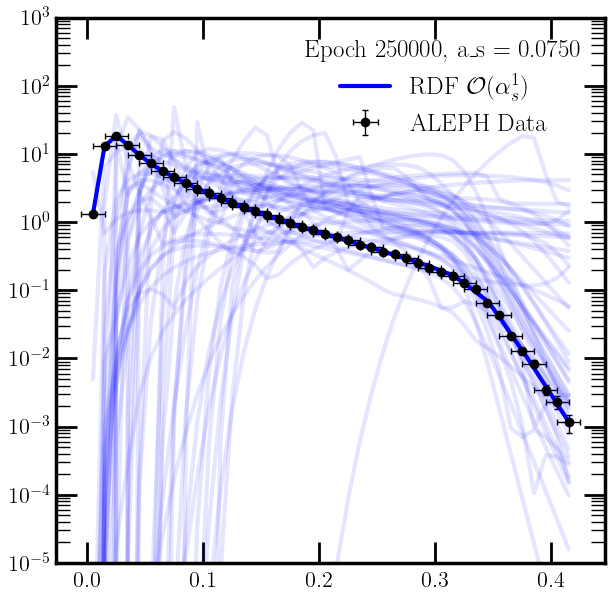

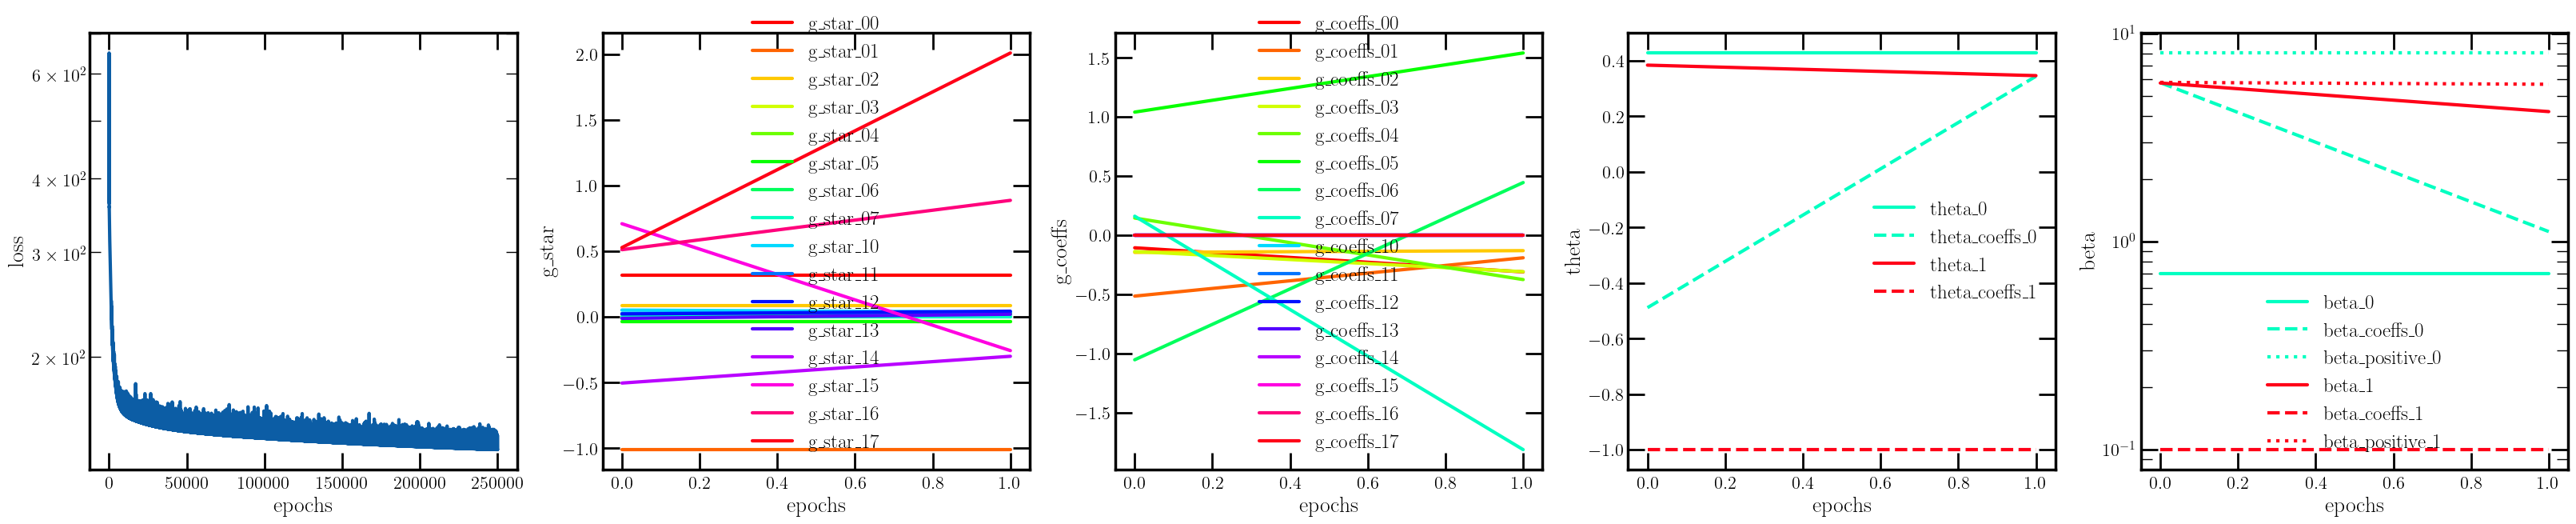

KeyboardInterrupt: 

In [ ]:

mis = [1, 2, 3,]
bogoscales = [2, ]

n_passes = 1

for mi in mis:


    alphas = jnp.linspace(0.075, 0.175, 401)
    d_alpha = alphas[1] - alphas[0]
    original_params = copy.deepcopy(params_array[mi-1])

    solver = _get_lbfgs(5000, 1e-10, 1000)

    # Run the solver once
    new_params = copy.deepcopy(params_array[mi-1])



    loss, new_params, losses, params_log = train(alphas[0],
                                                 new_params,
                                                 250000*4 , 
                                                 lr, 
                                                 jax_key, 
                                                 verbose=True, 
                                                 verbose_epochs=250000, 
                                                 bogo_init=True, 
                                                 early_stopping=250000*2, 
                                                 bogo_scale= 1, 
                                                 population=1024,
                                                 bogo_epochs=5000)


    print("Params after initial training:")
    print(new_params)
    print("Loss after initial training:")
    print(loss_function(new_params,  alphas[0], yLEPs, yLEP_errs, original_params))


    # new_last = pack_last_order(new_params)
    new_params = jax.tree_map(lambda x: jnp.asarray(x), new_params)
    new_params, _ = solver.run(new_params, alphas[0], original_params)
    # new_params = unpack_into_params((new_last), original_params)


    print("Params after solver:")
    print(new_params)

    print("Loss after solver:")
    print(loss_function(new_params,  alphas[0], yLEPs, yLEP_errs, original_params))

    # global accumulators across all passes (forward + backward)
    f_as_total, f_ls_total, f_ps_total = [], [], []
    b_as_total, b_ls_total, b_ps_total = [], [], []


    params = copy.deepcopy(new_params)


    # Start time
    start_time = time()

    chunk_size = 50



    for pass_idx in range(n_passes):

        ls, ps, as_ = [], [], []


        for c in range(0, len(alphas), chunk_size):

            alphas_chunk = alphas[c:min(c+chunk_size, len(alphas))]
            print(f"Starting chunk {alphas_chunk[0]} to {alphas_chunk[-1]} for order {mi}")

            # Skip hanging alphas to avoid triggering recompile
            if len(alphas_chunk) < chunk_size:
                continue

            as32 = lambda x: jnp.asarray(x, jnp.float32)
            params, jax_key, loss_vec, flats = scan_alphas(
                                                            params,
                                                            jax_key, 
                                                            alpha_begin=as32(alphas_chunk[0]), 
                                                            d_alpha=as32(d_alpha), 
                                                            n_alphas=len(alphas_chunk),
                                                            original_params=original_params,
                                                            epochs=25000*2,
                                                            lr=float(lr),
                                                            wd=float(weight_decay),
                                                            bogo_epochs=100*5,  
                                                            bogo_scale=as32(1/32)*mi,
                                                            population=32
                                                        )

            as_ += alphas_chunk.tolist()
            ls += loss_vec.tolist()
            ps += [copy.deepcopy(params) for _ in alphas_chunk]

            f_as_total += alphas_chunk.tolist()
            f_ls_total += loss_vec.tolist()
            f_ps_total += [copy.deepcopy(params) for _ in alphas_chunk]


            print(f"alpha: {alphas_chunk[-1]} loss: {ls[-1]}, Change in loss: {ls[-1] - ls[-len(alphas_chunk)]}")
            print(f"Time for chunk: {time() - start_time} seconds")
            start_time = time()


            fig, ax = newplot("column")

            all_losses = f_ls_total + b_ls_total
            min_ys = np.min(all_losses) if len(all_losses) else np.min(ls)
            # forward in one color, backward in another
            if len(f_ls_total):
                plt.errorbar(f_as_total, 2*np.array(np.array(f_ls_total) - min_ys), color = order_colors[mi], fmt = "x")
            if len(b_ls_total):
                plt.errorbar(b_as_total, 2*np.array(np.array(b_ls_total) - min_ys), color = darkcolors[mi-1], fmt = "o")

            argmin = np.argmin(all_losses) if len(all_losses) else np.argmin(ls)
            best_alpha = (f_as_total + b_as_total)[argmin] if len(all_losses) else as_[argmin]



            plt.axhline(1)
            plt.yscale("log")
            plt.xlabel(r"$\alpha_s$")
            plt.ylabel(r"-2$\Delta L$")
            plt.axvline(best_alpha)
            plt.show()



            with open(f"output_JAX/alphas_{mi}_{n}_{tag}.pkl", "wb") as f:
                pickle.dump(f_as_total + b_as_total, f)

            with open(f"output_JAX/ls_{mi}_{n}_{tag}.pkl", "wb") as f:
                pickle.dump(f_ls_total + b_ls_total, f)    

            with open(f"output_JAX/params_{mi}_{n}_{tag}.pkl", "wb") as f:
                pickle.dump(f_ps_total + b_ps_total, f)

            print("Saved intermediate results")


        # Run again, but backwards
        ls_backwards, ps_backwards, as_backwards = [], [], []
        alphas_backwards = alphas[::-1]

        for c in range(0, len(alphas_backwards), chunk_size):

            alphas_chunk = alphas_backwards[c:min(c+chunk_size, len(alphas_backwards))]
            print(f"Starting chunk {alphas_chunk[0]} to {alphas_chunk[-1]} for order {mi}")

            # Skip hanging alphas to avoid triggering recompile
            if len(alphas_chunk) < chunk_size:
                continue

            as32 = lambda x: jnp.asarray(x, jnp.float32)
            params, jax_key, loss_vec, flats = scan_alphas(
                                                            params,
                                                            jax_key, 
                                                            alpha_begin=as32(alphas_chunk[0]), 
                                                            d_alpha=as32(-d_alpha), 
                                                            n_alphas=len(alphas_chunk),
                                                            original_params=original_params,
                                                            epochs=25000*2,
                                                            lr=float(lr),
                                                            wd=float(weight_decay),
                                                            bogo_epochs=100*5,  
                                                            bogo_scale=as32(1/32)*mi,
                                                            population=32
                                                        )

            as_backwards += alphas_chunk.tolist()
            ls_backwards += loss_vec.tolist()
            ps_backwards += [copy.deepcopy(params) for _ in alphas_chunk]

            # accumulate totals
            b_as_total += alphas_chunk.tolist()
            b_ls_total += loss_vec.tolist()
            b_ps_total += [copy.deepcopy(params) for _ in alphas_chunk]

            print(f"alpha: {alphas_chunk[-1]} loss: {ls_backwards[-1]}, Change in loss: {ls_backwards[-1] - ls_backwards[-len(alphas_chunk)]}")
            print(f"Time for chunk: {time() - start_time} seconds")
            start_time = time()

            fig, ax = newplot("column")

            all_losses = f_ls_total + b_ls_total
            min_ys = np.min(all_losses)
            # forward in one color, backward in another
            if len(f_ls_total):
                plt.errorbar(f_as_total, 2*np.array(np.array(f_ls_total) - min_ys), color = order_colors[mi], fmt = "x")
            if len(b_ls_total):
                plt.errorbar(b_as_total, 2*np.array(np.array(b_ls_total) - min_ys), color = darkcolors[mi-1], fmt = "o")

            argmin = np.argmin(all_losses)
            best_alpha = (f_as_total + b_as_total)[argmin]

            plt.axhline(1)
            plt.yscale("log")
            plt.xlabel(r"$\alpha_s$")
            plt.ylabel(r"-2$\Delta L$")
            plt.axvline(best_alpha)
            plt.show()

            with open(f"output_JAX/alphas_{mi}_{n}_{tag}.pkl", "wb") as f:
                pickle.dump(f_as_total + b_as_total, f)

            with open(f"output_JAX/ls_{mi}_{n}_{tag}.pkl", "wb") as f:
                pickle.dump(f_ls_total + b_ls_total, f)    

            with open(f"output_JAX/params_{mi}_{n}_{tag}.pkl", "wb") as f:
                pickle.dump(f_ps_total + b_ps_total, f)

            print("Saved intermediate results")

    with open(f"output_JAX/alphas_{mi}_{n}_{tag}.pkl", "wb") as f:
            pickle.dump(as_ + as_backwards, f)

    with open(f"output_JAX/ls_{mi}_{n}_{tag}.pkl", "wb") as f:
        pickle.dump(ls + ls_backwards, f)   

    with open(f"output_JAX/params_{mi}_{n}_{tag}.pkl", "wb") as f:
        pickle.dump(ps + ps_backwards, f)

    print("Saved final results")

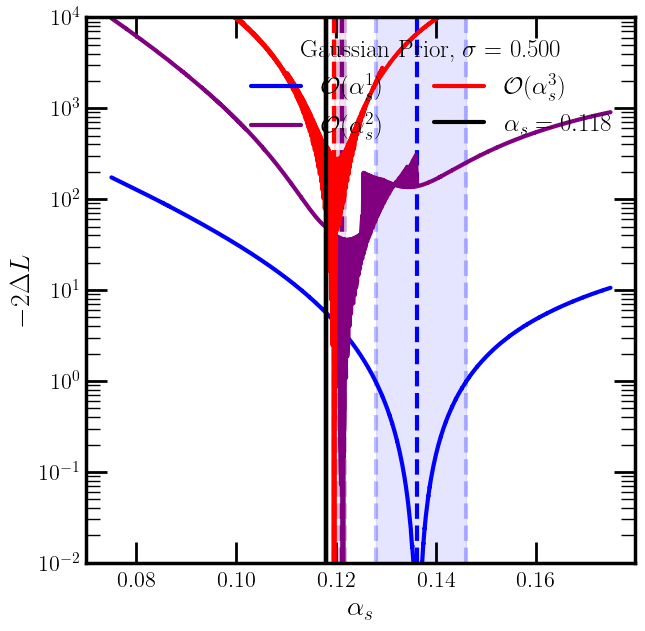

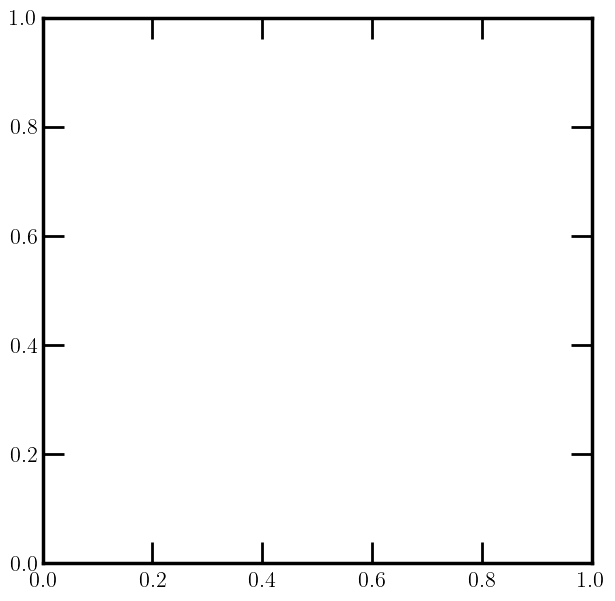

In [ ]:
fig, ax = newplot("full")

for mi in range(1, 4): 

    # try:

    
        with open(f"output_JAX/alphas_{mi}_{n}_{tag}.pkl", "rb") as f:
            alphas = np.array(pickle.load(f))

        with open(f"output_JAX/ls_{mi}_{n}_{tag}.pkl", "rb") as f:
            ls = np.array(pickle.load(f))


        idx = np.argsort(alphas)
        alphas = alphas[idx]
        ls = ls[idx]

        ls2 = 2 * ls

        min_ls = np.min(ls2)
        ls2 = ls2 - min_ls
        min_alpha = alphas[np.argmin(ls2)]

        alphas_below = alphas[ls2 < 1 + np.min(ls2)]
        low_alpha = alphas_below[0]
        high_alpha = alphas_below[-1]

        plt.plot(alphas, ls2, color = order_colors[mi], label = order_strings[mi])
        

        plt.axvline(min_alpha, color = order_colors[mi], ls = "--")
        plt.axvline(low_alpha, color = order_colors[mi], ls = "--", alpha = 0.25)
        plt.axvline(high_alpha, color = order_colors[mi], ls = "--", alpha = 0.25)

        plt.fill_betweenx(y = [0,1e4], x1 = low_alpha, x2 = high_alpha, color = "white", alpha = 0.5)
        plt.fill_betweenx(y = [0,1e4], x1 = low_alpha, x2 = high_alpha, color = order_colors[mi], alpha = 0.1)

        plt.yscale("log")
        plt.ylim(1e-2, 1e4)
        plt.axvline(0.118, color = "black")
        

plt.axvline(0.118, color = "black", label = r"$\alpha_s = 0.118$")

plt.xlabel(r"$\alpha_s$")
plt.ylabel(r"$-2\Delta L$")
plt.legend(title = r"Gaussian Prior, $\sigma = $" + f"{gaussian_prior_param : .3f}", loc = "upper right", ncol = 2)

plt.savefig(f"figures/gaussian_{dist}.pdf")

fix, ax = newplot("full")
dark_order_colors = order_colors


In [ ]:
print(loss)

17036.98046875


In [ ]:
.7 * (len(tLEP_bin_centers))

29.4

for (i, l)